# Enhancing Direct Marketing Strategies: Uplift Modeling with Advanced Machine Learning Approaches


# Project Summary

This project, primarily developed using the R programming language, explores how machine learning can enhance the product marketing stage. Using the Criteo Uplift dataset, the study applies Uplift Modeling to identify potential customers who are most likely to respond positively to direct marketing campaigns.

The study evaluates three different approaches:

Dual Uplift Modeling with hypercomputing integration

eXtreme Gradient Boosting (XGBoost)

A hybrid approach combining the Dual Uplift Model with XGBoost

Each model was assessed using statistical measures, and the business implications were analyzed. The findings indicate that Dual Uplift Modeling with hypercomputing outperforms conventional methods for handling large datasets. Additionally, while XGBoost is effective in predicting uplift, integrating it with the Dual Uplift Model significantly improves accuracy and reliability.

# Dataset Description

The Criteo Uplift dataset consists of 13 million rows, where each row represents an individual customer. The dataset captures various customer behaviors in response to marketing efforts and is provided in a comma-separated values (CSV) format.

Key Features:
f0 – f11: Numeric features representing customer characteristics and behavioral attributes (dense, float). Due to privacy concerns, the exact meanings of these features are undisclosed.

Treatment: A binary indicator (0 or 1) signifying whether the customer was exposed to a marketing treatment (1 = Yes, 0 = No).

Conversion: A binary indicator (0 or 1) representing whether the customer converted after the marketing treatment (1 = Yes, 0 = No).

Visit: A binary indicator (0 or 1) indicating whether the customer visited following the marketing effort (1 = Yes, 0 = No).

Exposure: A binary indicator (0 or 1) showing whether the customer was effectively exposed to the marketing campaign.

Privacy Considerations:
To maintain confidentiality regarding Criteo AI Lab's clients, users, and trade secrets, the true descriptions of f0 – f11 have not been disclosed. These features were analyzed in their anonymized form during the study.


# Uplift Modelling

Rzepakowski and Jaroszewicz (2012) define uplift modelling as a machine learning approach designed to predict the causal impact of an intervention (e.g., a marketing campaign) on an outcome variable. It does so by comparing two groups:

Treatment group – individuals who receive an intervention.

Control group – individuals who do not receive the intervention.

By incorporating the control group, the model estimates the incremental effect of the intervention on a given individual, rather than just predicting outcomes.

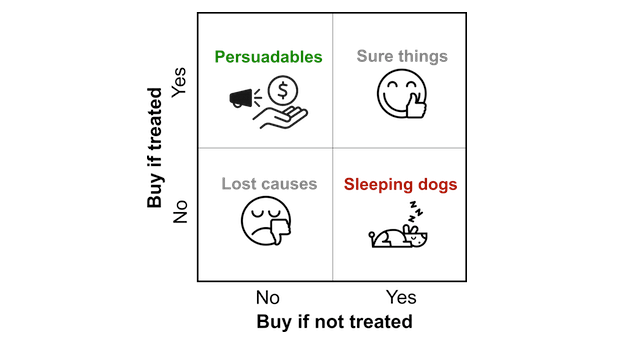
 Customer Segments in Uplift Modelling
The customer base is conceptually divided into four categories based on their response to the intervention:

1. Sure Things
Customers who would have purchased the product regardless of marketing efforts.

Targeting these customers does not increase revenue.

Instead, it increases expenses (e.g., marketing costs, discounts).

2. Lost Causes
Customers who will not purchase the product, even with marketing efforts.

These customers generate no revenue but incur marketing expenses.

However, costs are typically lower than those for Sure Things since they don’t utilize incentives.

3. Sleeping Dogs (Do-Not-Disturb)
Customers who would have purchased but are discouraged by the campaign.

Some consumers may have a negative reaction to marketing, making them less likely to buy.

It is crucial to avoid targeting this segment to prevent losses.

4. Persuadables
Customers who are influenced by the campaign and more likely to buy when targeted.

They would not have purchased without marketing.

These are the ideal target group, generating positive uplift and net profit.

Understanding Uplift
In summary, uplift measures the difference in customer behavior due to an intervention. Uplift modelling aims to:

Predict uplift based on customer features and treatment effects.

Identify individuals with high uplift to maximize campaign effectiveness.

By targeting only Persuadables, businesses can reduce unnecessary costs and increase ROI from marketing campaigns.


In [25]:
# Install R Packages
install.packages("caret", lib = "/kaggle/working")
install.packages("tools4uplift", lib = "/kaggle/working")
install.packages("ggplot2", lib = "/kaggle/working")
install.packages("ggcorrplot", lib = "/kaggle/working")
install.packages("xgboost", lib = "/kaggle/working")
install.packages("doParallel", lib = "/kaggle/working")
install.packages("caretEnsemble", lib = "/kaggle/working")

Warning message:
“package ‘caretEnsemble’ is not available for this version of R
‘caretEnsemble’ version 4.0.1 is in the repositories but depends on R (>= 4.1.0)

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”


# Data Collection and Loading

In [26]:
# Read the criteo-uplift dataset file into R
criteo_data_all <- read.csv("/kaggle/input/uplift-modeling/criteo-uplift-v2.1.csv", header = TRUE)

# Add a new column "customer_ID" with unique values starting from 1
criteo_data_all <- cbind(customer_ID = seq_len(nrow(criteo_data_all)), criteo_data_all)

head(criteo_data_all)

,customer_ID,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>
1,1,12.61636,10.05965,8.976429,4.679882,10.28053,4.115453,0.2944427,4.833815,3.955396,13.19006,5.300375,-0.1686792,1,0,0,0
2,2,12.61636,10.05965,9.002689,4.679882,10.28053,4.115453,0.2944427,4.833815,3.955396,13.19006,5.300375,-0.1686792,1,0,0,0
3,3,12.61636,10.05965,8.964775,4.679882,10.28053,4.115453,0.2944427,4.833815,3.955396,13.19006,5.300375,-0.1686792,1,0,0,0
4,4,12.61636,10.05965,9.002801,4.679882,10.28053,4.115453,0.2944427,4.833815,3.955396,13.19006,5.300375,-0.1686792,1,0,0,0
5,5,12.61636,10.05965,9.037999,4.679882,10.28053,4.115453,0.2944427,4.833815,3.955396,13.19006,5.300375,-0.1686792,1,0,0,0
6,6,12.61636,10.05965,8.904507,4.679882,10.28053,4.115453,0.2944427,4.833815,3.955396,13.19006,5.300375,-0.1686792,1,0,0,0


In [27]:
# Perform data sampling
sample_size <- 1000000
sample_indices <- sample(1:nrow(criteo_data_all), size = sample_size, replace = FALSE)
criteo_data <- criteo_data_all[sample_indices, ]

# Print the sampled data
head(criteo_data)

,customer_ID,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>
13329970,13329970,12.61636,10.05965,8.664882,4.6798816,10.28053,4.115453,0.2944427,4.833815,3.810663,20.05094,5.300375,-0.1686792,1,0,0,0
2712754,2712754,15.07788,10.05965,8.214383,3.9076619,10.28053,4.115453,-1.2882068,4.833815,3.971858,13.19006,5.300375,-0.1686792,1,0,0,0
6501961,6501961,26.10594,10.05965,8.214383,4.6798816,10.28053,4.115453,-8.2819710,4.833815,3.971858,13.19006,5.300375,-0.1686792,0,0,0,0
3606802,3606802,13.81394,10.05965,8.214383,-0.2770144,10.28053,4.115453,-9.8646205,4.833815,3.971858,13.19006,5.300375,-0.1686792,1,0,0,0
6897885,6897885,25.74724,10.05965,8.828417,4.6798816,10.28053,4.115453,-9.8646205,4.833815,3.835851,13.19006,5.300375,-0.1686792,1,0,0,0
9491846,9491846,22.74772,10.05965,8.813366,4.6798816,10.28053,2.230907,-15.2027742,10.923966,3.854508,13.19006,5.300375,-0.1686792,1,0,0,0


# Data Pre-processing

## Handling Missing Values

In [28]:
# Check for Missing values
missing_values <- colSums(criteo_data[, 2:13] == 0)

# Create data frame 
missing_val_data_frame <- data.frame(variable = names(missing_values), count = missing_values)

# Display Output
missing_val_data_frame

,variable,count
,<chr>,<dbl>
f0,f0,0
f1,f1,0
f2,f2,0
f3,f3,0
f4,f4,0
f5,f5,0
f6,f6,0
f7,f7,0
f8,f8,0


Having missing values in the dataset can lead to reducing the model's accuracy. Missing values in the dataset can arise due to various factors. Mainly, data collection mistakes and customer opt-outs. The above results visualises the criteo-uplift dataset feature columns not having any missing values.

## Identify Feature's Data Distribution (Boxplot)

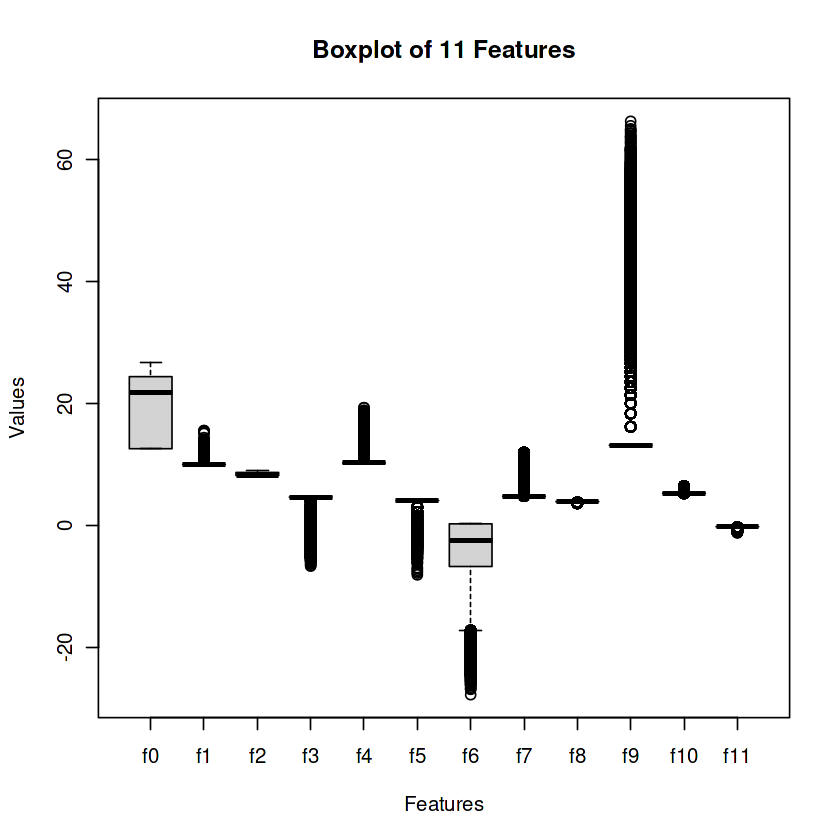

In [29]:
# Create a data subset with the features
criteo_subset <- criteo_data[, 2:13]

# Create boxplot
boxplot(criteo_subset, main = "Boxplot of 11 Features",xlab = "Features", ylab = "Values")

The "box" and "whisker" known as boxplot is a graphical representation that can be used to understand the data spread within the selected feature. In the boxplot, the box represents the interquartile range (IQR), which includes the middle 50% of the data and the line inside the box represents the median of the selected data. In addition to that, "whiskers" can be used to explain the data range and if the dataset contains any outliers, the same will be plotted outside these whiskers.

As per the criteo uplift dataset, Only features f0 and f2 have no outliers and features f6 and f9 have the highest outliers. Although, features such as f3, f4 and f5 seem to have a positive skewness, while f0, f1, f4, f7 and f9 seem to have negative skewness can be observed in the dataset.

## Identify Correlation Coefficient

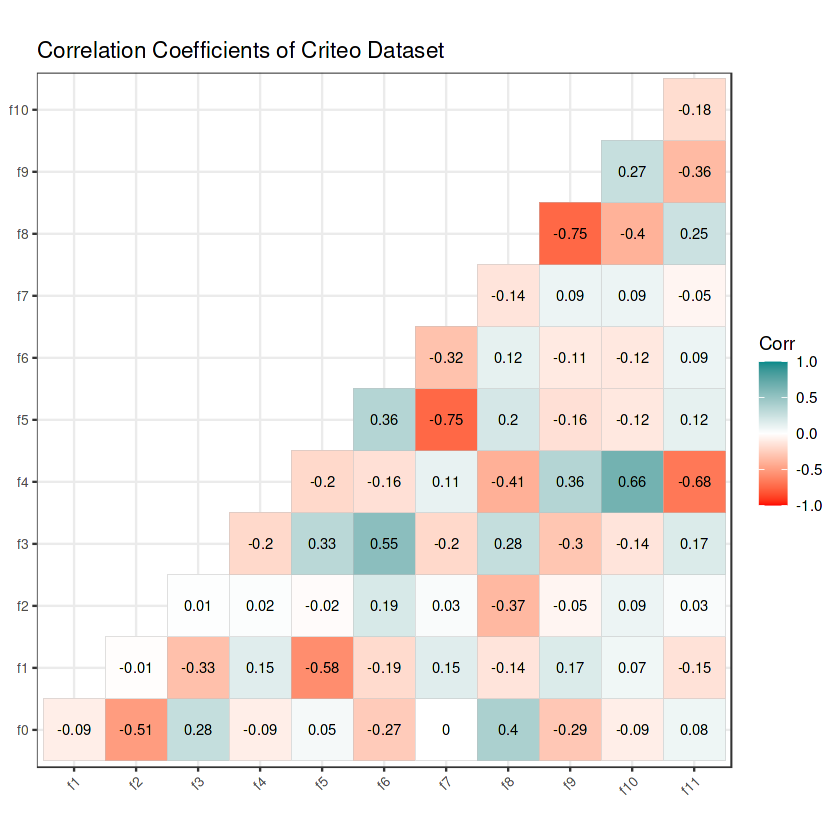

In [30]:
# Calculate the correlation
cor_matrix <- cor(criteo_subset)

# Display correlation in a heatmap
require(ggcorrplot)
library(ggplot2)
corr <- round(cor_matrix,2) 
ggcorrplot(corr, type = "lower",tl.cex = 8, lab = TRUE, lab_size = 3, colors = c("red", "white", "cyan4"), title="Correlation Coefficients of Criteo Dataset", 
           ggtheme=theme_bw)

The above results explains the correlation coefficients of feature variables. The variables having positive correlations are shaded in cyan colour, negative correlations are shaded in red colour and if there is no correlation, that is shown in white colour. As per Figure 8, features f4 and f10 have the highest positive correlation when compared to other feature's correlations and features f5 and f7 have the highest negative correlation while f0 and f7 display no correlation.

## Disregard unnecessary columns

In [31]:
# Drop the "exposure" column
dataset <- criteo_data[, -which(names(criteo_data) == "exposure")]

# Display Output
head(dataset)

,customer_ID,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
13329970,13329970,12.61636,10.05965,8.664882,4.6798816,10.28053,4.115453,0.2944427,4.833815,3.810663,20.05094,5.300375,-0.1686792,1,0,0
2712754,2712754,15.07788,10.05965,8.214383,3.9076619,10.28053,4.115453,-1.2882068,4.833815,3.971858,13.19006,5.300375,-0.1686792,1,0,0
6501961,6501961,26.10594,10.05965,8.214383,4.6798816,10.28053,4.115453,-8.2819710,4.833815,3.971858,13.19006,5.300375,-0.1686792,0,0,0
3606802,3606802,13.81394,10.05965,8.214383,-0.2770144,10.28053,4.115453,-9.8646205,4.833815,3.971858,13.19006,5.300375,-0.1686792,1,0,0
6897885,6897885,25.74724,10.05965,8.828417,4.6798816,10.28053,4.115453,-9.8646205,4.833815,3.835851,13.19006,5.300375,-0.1686792,1,0,0
9491846,9491846,22.74772,10.05965,8.813366,4.6798816,10.28053,2.230907,-15.2027742,10.923966,3.854508,13.19006,5.300375,-0.1686792,1,0,0


## Numerical Feature Standardisation

In [32]:
# Z-score normalization function
normalize_zscore <- function(x) {
  (x - mean(x)) / sd(x)
}

# Apply z-score normalization to numeric features
numeric_features <- c("f0", "f1", "f2", "f3", "f4", "f5", "f6", "f7", "f8", "f9", "f10", "f11")
dataset[, numeric_features] <- apply(dataset[, numeric_features], 2, normalize_zscore)

# Display Output
head(dataset)

,customer_ID,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
13329970,13329970,-1.3010203,-0.09878374,0.7266209,0.3739084,-0.1699581,0.2018042,0.9707833,-0.222789,-2.1688662,0.5740384,-0.1962774,0.1001788,1,0,0
2712754,2712754,-0.8435362,-0.09878374,-0.7766070,-0.2046008,-0.1699581,0.2018042,0.6248423,-0.222789,0.6759997,-0.4035324,-0.1962774,0.1001788,1,0,0
6501961,6501961,1.2060757,-0.09878374,-0.7766070,0.3739084,-0.1699581,0.2018042,-0.9038788,-0.222789,0.6759997,-0.4035324,-0.1962774,0.1001788,0,0,0
3606802,3606802,-1.0784463,-0.09878374,-0.7766070,-3.3395552,-0.1699581,0.2018042,-1.2498198,-0.222789,0.6759997,-0.4035324,-0.1962774,0.1001788,1,0,0
6897885,6897885,1.1394096,-0.09878374,1.2723085,0.3739084,-0.1699581,0.2018042,-1.2498198,-0.222789,-1.7243346,-0.4035324,-0.1962774,0.1001788,1,0,0
9491846,9491846,0.5819358,-0.09878374,1.2220842,0.3739084,-0.1699581,-4.1634646,-2.4166518,4.817765,-1.3950621,-0.4035324,-0.1962774,0.1001788,1,0,0


These normalised data centred around a mean of 0 and a standard deviation of 1. This helps to prevent any feature from dominating the model based on its scale.

# Model Development

## Data Splitting

In [33]:
# Load required libraries
library(caret)

# Split the dataset. 70% training data and 30% testing data
set.seed(1000)
train_indices <- createDataPartition(dataset$treatment, p = 0.7, list = FALSE)
train_data <- dataset[train_indices, ]
test_data <- dataset[-train_indices, ]

## Baseline Model Development

In [34]:
# Install tools4uplift package (if not already installed)
if (!requireNamespace("tools4uplift", quietly = TRUE)) {
  install.packages("tools4uplift")
}

# Load required libraries
library(tools4uplift)

# Set predictor varible 
predictor_vars <- c("f0", "f1", "f2", "f3", "f4", "f5", "f6", "f7", "f8", "f9", "f10", "f11")

# Train DualUplift Model using Training Data
base.tm <- DualUplift(train_data, "treatment", "visit", predictors = predictor_vars)

# Disply Dualuplift model control group
summary(base.tm[[1]])
# Disply Dualuplift modeltreatment group
summary(base.tm[[2]])

# Perform Uplift prediction using Testing Data
base.tm_valid_pred <- predict(base.tm, newdata = test_data)

# Display Output
head(base.tm_valid_pred)


Call:
glm(formula = model_formula, family = binomial(link = "logit"), 
    data = mydata0)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5574  -0.1400  -0.1126  -0.1028   3.6353  

Coefficients:
            Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -4.47024    0.03260 -137.112  < 2e-16 ***
f0          -0.30167    0.02955  -10.210  < 2e-16 ***
f1           0.04045    0.01772    2.283 0.022454 *  
f2          -0.63233    0.03377  -18.726  < 2e-16 ***
f3           0.07239    0.02397    3.020 0.002526 ** 
f4          -0.05029    0.01667   -3.016 0.002559 ** 
f5           0.12332    0.02799    4.406 1.05e-05 ***
f6          -0.12563    0.02868   -4.381 1.18e-05 ***
f7           0.03662    0.02548    1.437 0.150646    
f8          -1.33551    0.02865  -46.612  < 2e-16 ***
f9           0.08118    0.02263    3.588 0.000334 ***
f10          0.01679    0.01453    1.156 0.247832    
f11         -0.04674    0.01307   -3.577 0.000348 ***
---
Signif. codes:  0 ‘


Call:
glm(formula = model_formula, family = binomial(link = "logit"), 
    data = mydata1)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.6905  -0.1671  -0.1245  -0.1090   3.6284  

Coefficients:
             Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -4.238083   0.012368 -342.658  < 2e-16 ***
f0          -0.368911   0.011427  -32.285  < 2e-16 ***
f1           0.005108   0.005569    0.917   0.3591    
f2          -0.600198   0.012727  -47.159  < 2e-16 ***
f3           0.017455   0.008544    2.043   0.0411 *  
f4          -0.057691   0.006570   -8.781  < 2e-16 ***
f5           0.053707   0.008387    6.403 1.52e-10 ***
f6          -0.245046   0.010565  -23.195  < 2e-16 ***
f7           0.052912   0.008239    6.422 1.34e-10 ***
f8          -1.270492   0.011011 -115.386  < 2e-16 ***
f9           0.101212   0.008712   11.617  < 2e-16 ***
f10          0.004003   0.005636    0.710   0.4776    
f11         -0.040069   0.005118   -7.829 4.92e-15 ***
---
Signi

2712754       6897885       9128782       4847551       1073326 
 0.0021794746  0.0084105351  0.0007614818 -0.0068253526  0.0008412239 
      3068821 
 0.0055118181

## Qini Table Development

In [35]:
# Combine the predicted uplift with the treatment and outcome variables
qini_data <- cbind(test_data[, c("customer_ID","treatment", "visit")], uplift = base.tm_valid_pred)

# Sort the predicted uplift daat in descending order
sorted_data <- qini_data[order(-qini_data$uplift), ]

# Calculate the cumulative uplift for the treated and control groups
cum_uplift_treated <- cumsum(sorted_data$treatment * sorted_data$uplift)
cum_uplift_control <- cumsum((1 - sorted_data$treatment) * sorted_data$uplift)

# Calculate the incremental uplift for the treated and control groups
inc_uplift_treated <- c(0, diff(cum_uplift_treated ))
inc_uplift_control <- c(0, diff(cum_uplift_control ))

# Calculate the Qini coefficient
qini_coefficient <- inc_uplift_treated - inc_uplift_control 

# Create the Qini table
base.tm.perf <- data.frame(Group = 1:length(qini_coefficient),
  Treated = cumsum(sorted_data$treatment),
  Control = cumsum(1 - sorted_data$treatment),
  Treated_Positive = cumsum(sorted_data$treatment * (sorted_data$uplift > 0)),
  Control_Positive = cumsum((1 - sorted_data$treatment) * (sorted_data$uplift > 0)),
  Cum_Uplift_Treated = cum_uplift_treated,
  Cum_Uplift_Control = cum_uplift_control,
  Inc_Uplift_Treated = inc_uplift_treated,
  Inc_Uplift_Control = inc_uplift_control,
  Qini_Coefficient = qini_coefficient)

# Print the Qini table
head(base.tm.perf)

,Group,Treated,Control,Treated_Positive,Control_Positive,Cum_Uplift_Treated,Cum_Uplift_Control,Inc_Uplift_Treated,Inc_Uplift_Control,Qini_Coefficient
,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,0,1,0,0.4190523,0,0.0000000,0,0.0000000
2,2,2,0,2,0,0.8197006,0,0.4006484,0,0.4006484
3,3,3,0,3,0,1.2201743,0,0.4004736,0,0.4004736
4,4,4,0,4,0,1.6204721,0,0.4002978,0,0.4002978
5,5,5,0,5,0,2.0132730,0,0.3928009,0,0.3928009
6,6,6,0,6,0,2.4038369,0,0.3905640,0,0.3905640


## Qini Curve Development

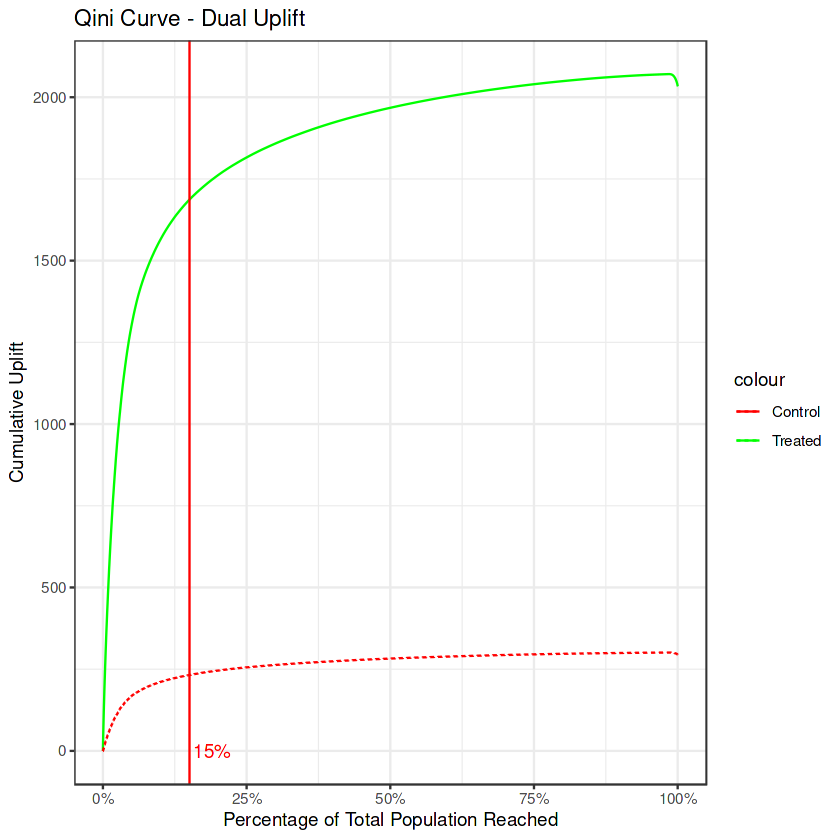

In [36]:
# Load required libraries
library(ggplot2)

# Calculate the percentage of the total population reached
total_population <- nrow(sorted_data)
percentage_reached <- seq(0, 100, length.out = total_population)

# Create a data frame for the Qini curve
qini_curve_data <- data.frame(Percentage_Reached = percentage_reached,
                              Cum_Uplift_Treated = cum_uplift_treated,
                              Cum_Uplift_Control = cum_uplift_control)

# Plot the Qini curve
ggplot(qini_curve_data, aes(x = Percentage_Reached)) +
  geom_line(aes(y = Cum_Uplift_Treated, color = "Treated"), linetype = "solid") +
  geom_line(aes(y = Cum_Uplift_Control, color = "Control"), linetype = "dashed") +
  scale_color_manual(values = c("Treated" = "green", "Control" = "red")) +
  labs(x = "Percentage of Total Population Reached",
       y = "Cumulative Uplift",
       title = "Qini Curve - Dual Uplift") +
  theme_bw() +
  geom_vline(xintercept = 15, color = "red", linetype = "solid") +
  scale_x_continuous(labels = scales::percent_format(scale = 1)) +
  annotate("text", x = 19, y = -0.05, label = "15%", color = "red")

The above results visualises the qini curve that was developed using the dual uplift model for both Treated and control groups. The first 0%-15% of the population represented in the curve can be identified as “Persuadables” in the given dataset. The 15%-98% of the population can be identified as “Sure things” and “Lost causes”. While 98%-100% of the population can be identified as “Sleeping dogs”. 

## Alternative Model Development (XGBoost)

In [37]:
# Load required libraries
library(tools4uplift)
library(xgboost)
library(pROC)

# Train the XGBoost uplift model
xgboost_model <- xgboost(data = as.matrix(train_data[, predictor_vars]), 
                         label = train_data$visit, 
                         treatment = train_data$treatment,
                         objective = "binary:logistic",
                         nrounds = 50)

# Make predictions on the validation set
xgboost_pred <- predict(xgboost_model, newdata = as.matrix(test_data[, predictor_vars]))

# Calculate uplift
xgboost_uplift <- xgboost_pred

# Calculate accuracy
xgboost_accuracy <- sum(ifelse(xgboost_uplift >= 0.5, 1, 0) == test_data$visit) / nrow(test_data)

# Calculate AUC
xgboost_auc <- roc(test_data$visit, xgboost_uplift)$auc

[04:43:28] WARNING: src/learner.cc:767: 
Parameters: { "treatment" } are not used.

[1]	train-logloss:0.468561 
[2]	train-logloss:0.345097 
[3]	train-logloss:0.268208 
[4]	train-logloss:0.217477 
[5]	train-logloss:0.183009 
[6]	train-logloss:0.159159 
[7]	train-logloss:0.142478 
[8]	train-logloss:0.130739 
[9]	train-logloss:0.122420 
[10]	train-logloss:0.116523 
[11]	train-logloss:0.112358 
[12]	train-logloss:0.109424 
[13]	train-logloss:0.107345 
[14]	train-logloss:0.105874 
[15]	train-logloss:0.104857 
[16]	train-logloss:0.104137 
[17]	train-logloss:0.103626 
[18]	train-logloss:0.103257 
[19]	train-logloss:0.102980 
[20]	train-logloss:0.102787 
[21]	train-logloss:0.102611 
[22]	train-logloss:0.102473 
[23]	train-logloss:0.102379 
[24]	train-logloss:0.102314 
[25]	train-logloss:0.102242 
[26]	train-logloss:0.102141 
[27]	train-logloss:0.102054 
[28]	train-logloss:0.101960 
[29]	train-logloss:0.101828 
[30]	train-logloss:0.101799 
[31]	train-logloss:0.101777 
[32]	train-logloss:0.10166

Setting levels: control = 0, case = 1

Setting direction: controls < cases



## Qini Table Development

In [38]:
# Combine the predicted uplift with the treatment and outcome variables
xgb_qini_data <- cbind(test_data[, c("customer_ID","treatment", "visit")], uplift = xgboost_pred)

# Sort the data by predicted uplift in descending order
xgb_sorted_data <- xgb_qini_data[order(-xgb_qini_data$uplift), ]

# Calculate the cumulative uplift for the treated and control groups
xgb_cum_uplift_treated <- cumsum(xgb_sorted_data$treatment * xgb_sorted_data$uplift)
xgb_cum_uplift_control <- cumsum((1 - xgb_sorted_data$treatment) * xgb_sorted_data$uplift)

# Calculate the incremental uplift for the treated and control groups
xgb_inc_uplift_treated <- c(0, diff(xgb_cum_uplift_treated ))
xgb_inc_uplift_control <- c(0, diff(xgb_cum_uplift_control ))

# Calculate the Qini coefficient for each group
xgb_qini_coefficient <- xgb_inc_uplift_treated - xgb_inc_uplift_control 

# Create the Qini table
xgb_base.tm.perf <- data.frame(Group = 1:length(xgb_qini_coefficient),
  Treated = cumsum(xgb_sorted_data$treatment),
  Control = cumsum(1 - xgb_sorted_data$treatment),
  Treated_Positive = cumsum(xgb_sorted_data$treatment * (xgb_sorted_data$uplift > 0)),
  Control_Positive = cumsum((1 - xgb_sorted_data$treatment) * (xgb_sorted_data$uplift > 0)),
  Cum_Uplift_Treated = xgb_cum_uplift_treated,
  Cum_Uplift_Control = xgb_cum_uplift_control,
  Inc_Uplift_Treated = xgb_inc_uplift_treated,
  Inc_Uplift_Control = xgb_inc_uplift_control,
  Qini_Coefficient = xgb_qini_coefficient)

# Print the Qini table
head(xgb_base.tm.perf)

,Group,Treated,Control,Treated_Positive,Control_Positive,Cum_Uplift_Treated,Cum_Uplift_Control,Inc_Uplift_Treated,Inc_Uplift_Control,Qini_Coefficient
,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,0,1,0,0.9405679,0,0.0000000,0,0.0000000
2,2,2,0,2,0,1.8779222,0,0.9373543,0,0.9373543
3,3,3,0,3,0,2.8115203,0,0.9335980,0,0.9335980
4,4,4,0,4,0,3.7438323,0,0.9323120,0,0.9323120
5,5,5,0,5,0,4.6747069,0,0.9308746,0,0.9308746
6,6,6,0,6,0,5.6042902,0,0.9295834,0,0.9295834


## Qini Curve Development

[1] "XGBoost accuracy: 0.958916666666667"
[1] "XGBoost AUC: 0.945543004251766"


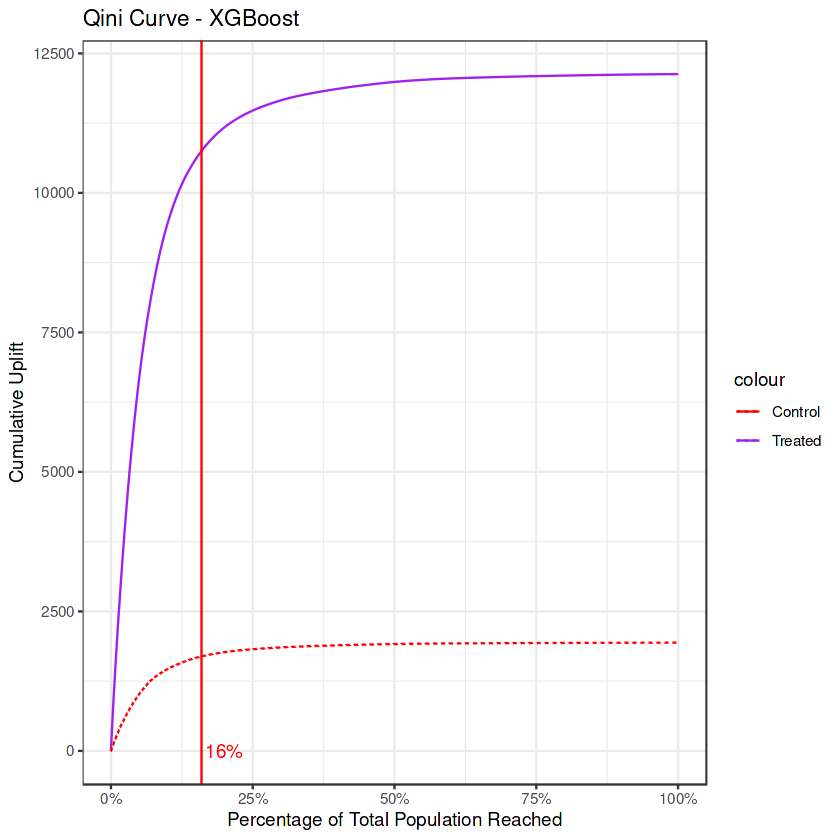

In [39]:
# Calculate the percentage of the total population reached
xgb_total_population <- nrow(xgb_sorted_data)
xgb_percentage_reached <- seq(0, 100, length.out = xgb_total_population)

# Create a data frame for the Qini curve
xgb_qini_curve_data <- data.frame(Percentage_Reached = xgb_percentage_reached,
                              Cum_Uplift_Treated = xgb_cum_uplift_treated,
                              Cum_Uplift_Control = xgb_cum_uplift_control)

# Plot the Qini curve
ggplot(xgb_qini_curve_data, aes(x = Percentage_Reached)) +
  geom_line(aes(y = Cum_Uplift_Treated, color = "Treated"), linetype = "solid") +
  geom_line(aes(y = Cum_Uplift_Control, color = "Control"), linetype = "dashed") +
  scale_color_manual(values = c("Treated" = "purple", "Control" = "red")) +
  labs(x = "Percentage of Total Population Reached",
       y = "Cumulative Uplift",
       title = "Qini Curve - XGBoost") +
   theme_bw() +
  geom_vline(xintercept = 16, color = "red", linetype = "solid") +
  scale_x_continuous(labels = scales::percent_format(scale = 1)) +
  annotate("text", x = 20, y = -0.05, label = "16%", color = "red")

# Print the accuracy and AUC
print(paste("XGBoost accuracy:", xgboost_accuracy))
print(paste("XGBoost AUC:", xgboost_auc))

The XGBoost model has 95% accuracy. This further explains the proportion that the model correctly predicts instances out of the total instances. The AUC value of 0.944 indicates that the model is well fit for the criteo uplift dataset. In the given dataset 0%-16% of the population represented in the curve can be identified as “Persuadables”.

## Combined Model Development

In [40]:
# Load required libraries
library(tools4uplift)
library(xgboost)
library(pROC)

# Train the Dual Uplift model
dual_uplift_model_xg <- DualUplift(train_data, "treatment", "visit", predictors = predictor_vars)

# Make predictions using the Dual Uplift model
dual_uplift_pred_xg <- predict(dual_uplift_model_xg, newdata = test_data)


# Train the XGBoost uplift model
xgboost_model <- xgboost(data = as.matrix(train_data[, predictor_vars]), 
                          label = train_data$visit, 
                          treatment = train_data$treatment,
                          objective = "binary:logistic",
                          nrounds = 50)

# Make predictions on the XGBoost uplift mode
xgboost_pred <- predict(xgboost_model, newdata = as.matrix(test_data[, predictor_vars]))

# Calculate the soft votes
soft_votes_xgb_dual_up <- (dual_uplift_pred_xg + xgboost_pred) / 2

# Make the final predictions
final_pred_xgb_dual_up <- ifelse(soft_votes_xgb_dual_up > 0.5, 1, 0)

# Evaluate the performance of the combined model (e.g., accuracy or AUC)
accuracy_xgb_dual_up <- mean(final_pred_xgb_dual_up == test_data$visit)
auc_xgb_dual_up <- roc(test_data$visit, soft_votes_xgb_dual_up)$auc

[04:43:53] WARNING: src/learner.cc:767: 
Parameters: { "treatment" } are not used.

[1]	train-logloss:0.468561 
[2]	train-logloss:0.345097 
[3]	train-logloss:0.268208 
[4]	train-logloss:0.217477 
[5]	train-logloss:0.183009 
[6]	train-logloss:0.159159 
[7]	train-logloss:0.142478 
[8]	train-logloss:0.130739 
[9]	train-logloss:0.122420 
[10]	train-logloss:0.116523 
[11]	train-logloss:0.112358 
[12]	train-logloss:0.109424 
[13]	train-logloss:0.107345 
[14]	train-logloss:0.105874 
[15]	train-logloss:0.104857 
[16]	train-logloss:0.104137 
[17]	train-logloss:0.103626 
[18]	train-logloss:0.103257 
[19]	train-logloss:0.102980 
[20]	train-logloss:0.102787 
[21]	train-logloss:0.102611 
[22]	train-logloss:0.102473 
[23]	train-logloss:0.102379 
[24]	train-logloss:0.102314 
[25]	train-logloss:0.102242 
[26]	train-logloss:0.102141 
[27]	train-logloss:0.102054 
[28]	train-logloss:0.101960 
[29]	train-logloss:0.101828 
[30]	train-logloss:0.101799 
[31]	train-logloss:0.101777 
[32]	train-logloss:0.10166

Setting levels: control = 0, case = 1

Setting direction: controls < cases



## Qini Table Development

In [41]:
# Combine the predicted uplift with the treatment and outcome variables
com_xgb_qini_data <- cbind(test_data[, c("customer_ID","treatment", "visit")], uplift = soft_votes_xgb_dual_up)

# Sort the data by predicted uplift in descending order
com_xgb_sorted_data <- com_xgb_qini_data[order(-com_xgb_qini_data$uplift), ]

# Calculate the cumulative uplift for the treated and control groups
com_xgb_cum_uplift_treated <- cumsum(com_xgb_sorted_data$treatment * com_xgb_sorted_data$uplift)
com_xgb_cum_uplift_control <- cumsum((1 - com_xgb_sorted_data$treatment) * com_xgb_sorted_data$uplift)

# Calculate the incremental uplift for the treated and control groups
com_xgb_inc_uplift_treated <- c(0, diff(com_xgb_cum_uplift_treated ))
com_xgb_inc_uplift_control <- c(0, diff(com_xgb_cum_uplift_control ))

# Calculate the Qini coefficient for each group
com_xgb_qini_coefficient <- com_xgb_inc_uplift_treated - com_xgb_inc_uplift_control 

# Create the Qini table
com_xgb_base.tm.perf <- data.frame(Group = 1:length(com_xgb_qini_coefficient),
  Treated = cumsum(com_xgb_sorted_data$treatment),
  Control = cumsum(1 - com_xgb_sorted_data$treatment),
  Treated_Positive = cumsum(com_xgb_sorted_data$treatment * (com_xgb_sorted_data$uplift > 0)),
  Control_Positive = cumsum((1 - com_xgb_sorted_data$treatment) * (com_xgb_sorted_data$uplift > 0)),
  Cum_Uplift_Treated = com_xgb_cum_uplift_treated,
  Cum_Uplift_Control = com_xgb_cum_uplift_control,
  Inc_Uplift_Treated = com_xgb_inc_uplift_treated,
  Inc_Uplift_Control = com_xgb_inc_uplift_control,
  Qini_Coefficient = com_xgb_qini_coefficient)

# Print the Qini table
head(com_xgb_base.tm.perf)

,Group,Treated,Control,Treated_Positive,Control_Positive,Cum_Uplift_Treated,Cum_Uplift_Control,Inc_Uplift_Treated,Inc_Uplift_Control,Qini_Coefficient
,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,0,1,0,0.5982849,0,0.0000000,0,0.0000000
2,2,2,0,2,0,1.1876187,0,0.5893338,0,0.5893338
3,3,3,0,3,0,1.7765720,0,0.5889533,0,0.5889533
4,4,4,0,4,0,2.3615880,0,0.5850159,0,0.5850159
5,5,5,0,5,0,2.9319607,0,0.5703727,0,0.5703727
6,6,6,0,6,0,3.5003240,0,0.5683633,0,0.5683633


## Qini Curve Development

[1] "Combined model accuracy: 0.953476666666667"
[1] "Combined model AUC: 0.945002671528535"


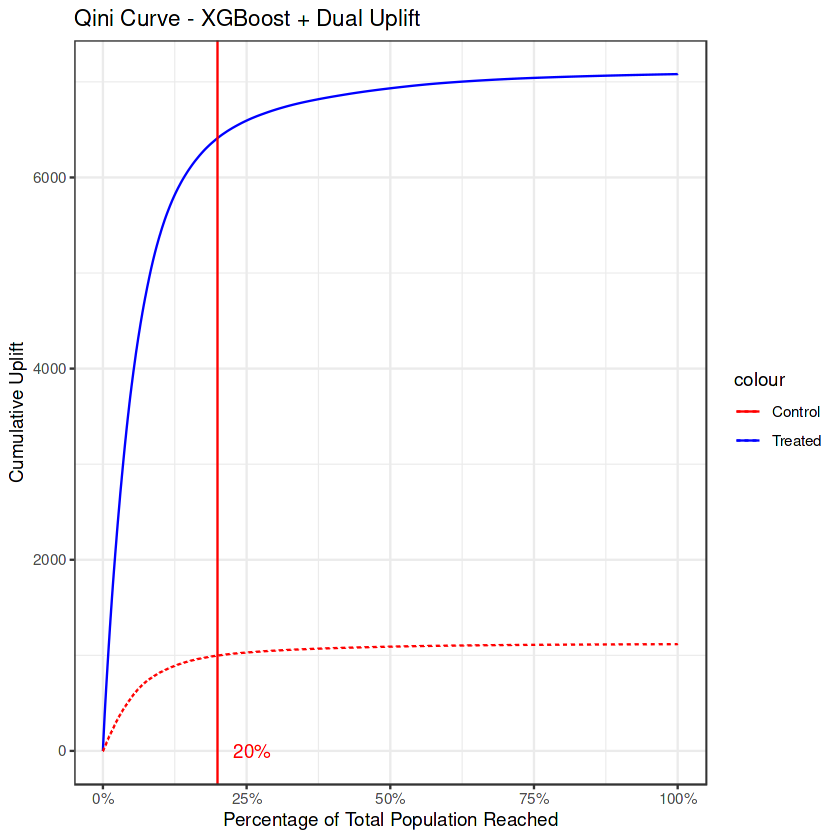

In [42]:
# Calculate the percentage of the total population reached
com_xgb_total_population <- nrow(com_xgb_sorted_data)
com_xgb_percentage_reached <- seq(0, 100, length.out = com_xgb_total_population)

# Create a data frame for the Qini curve
com_xgb_qini_curve_data <- data.frame(Percentage_Reached = com_xgb_percentage_reached,Cum_Uplift_Treated = com_xgb_cum_uplift_treated, Cum_Uplift_Control = com_xgb_cum_uplift_control)

# Plot the Qini curve
ggplot(com_xgb_qini_curve_data, aes(x = Percentage_Reached)) +
  geom_line(aes(y = Cum_Uplift_Treated, color = "Treated"), linetype = "solid") +
  geom_line(aes(y = Cum_Uplift_Control, color = "Control"), linetype = "dashed") +
  scale_color_manual(values = c("Treated" = "blue", "Control" = "red")) +
  labs(x = "Percentage of Total Population Reached",
       y = "Cumulative Uplift",
       title = "Qini Curve - XGBoost + Dual Uplift") +
   theme_bw() +
  geom_vline(xintercept = 20, color = "red", linetype = "solid") +
  scale_x_continuous(labels = scales::percent_format(scale = 1)) +
  annotate("text", x = 26, y = -0.05, label = "20%", color = "red")

# Print the evaluation results
print(paste("Combined model accuracy:", accuracy_xgb_dual_up))
print(paste("Combined model AUC:", auc_xgb_dual_up))

The combined model has 95% accuracy while an AUC value of 0.943 further indicates that the model is well fit for the criteo uplift dataset. In the given dataset 0%-20% of the population represented in the curve can be identified as “Persuadables”.

## Integrate Parallel Processing with Dual Uplift Model

In [43]:
# Load required libraries
library(tools4uplift)
library(parallel)

# Define the number of models and cores
num_models <- 12
num_cores <- 8
num_datasets <- 12

# Set up parallel processing
cl <- makeCluster(num_cores)

# Define the dataset and predictor_vars here
dataset <- dataset

# Create a list to store the training and testing data for each model
train_test_data_list <- list()

# Divide the dataset into num_datasets subsets
dataset_splits <- split(dataset, rep(1:num_datasets, each = nrow(dataset) / num_datasets))

# Iterate over the number of models
for (i in 1:num_models) {
  # Extract the subset
  subset_data <- dataset_splits[[i]]
  
  # Split the subset into training and testing data
  set.seed(123 + i)
  train_indices <- sample(1:nrow(subset_data), size = 0.7 * nrow(subset_data), replace = FALSE)
  train_data <- subset_data[train_indices, ]
  test_data <- subset_data[-train_indices, ]
  
  # Store the training and test data in the list
  train_test_data_list[[i]] <- list(train_data = train_data, test_data = test_data)
}

# Train Dual Uplift models on different subsets of the data using parallel processing
trained_models <- parLapply(cl, 1:num_models, function(i, train_test_data) {
  library(tools4uplift)
  
  predictor_vars <- c("f0", "f1", "f2", "f3", "f4", "f5", "f6", "f7", "f8", "f9", "f10", "f11")
  
  # Extract the training data
  train_data <- train_test_data[[i]]$train_data

  # Train a Dual Uplift model
  hyper_model <- DualUplift(train_data, "treatment", "visit", predictors = predictor_vars)

  return(list(hyper_model = hyper_model))
}, train_test_data = train_test_data_list)

# Stop parallel processing
stopCluster(cl)

# Make predictions on the test data using each trained model
predictions_list <- list()

for (i in 1:num_models) {
  # Extract the test data
  test_data <- train_test_data_list[[i]]$test_data
  
  # Extract the required columns from the test data
  customer_ID <- test_data$customer_ID
  treatment <- test_data$treatment
  visit <- test_data$visit

  # Extract the trained model
  hyper_model <- trained_models[[i]]$hyper_model

  # Make predictions on the test data
  predictions <- predict(hyper_model, newdata = test_data)

  # Create a data frame with customer_ID, treatment, visit, and predictions
  predictions_df <- data.frame(
    customer_ID = customer_ID,
    treatment = treatment,
    visit = visit,
    prediction = predictions
  )

  # Store the predictions data frame in the list
  predictions_list[[i]] <- predictions_df
}

# Combine predictions from all models
all_predictions <- list()

for (i in 1:num_models) {
  # Combine predictions from the ith model
  all_predictions[[i]] <- predictions_list[[i]]
}

# Combine predictions from all models into a single data frame
ensemble_predictions <- do.call("rbind", all_predictions)

# Display the data frame
head(ensemble_predictions)

Warning message in split.default(x = seq_len(nrow(x)), f = f, drop = drop, ...):
“data length is not a multiple of split variable”


,customer_ID,treatment,visit,prediction
,<int>,<int>,<int>,<dbl>
2712754,2712754,1,0,0.001826150
6501961,6501961,0,0,0.003250371
3606802,3606802,1,0,0.007551479
9491846,9491846,1,0,0.031565194
1933244,1933244,1,1,-0.035224362
1824403,1824403,1,0,0.001002498


## Qini Table Development

In [44]:
# Combine the predicted uplift with the treatment and outcome variables
hyper_qini_data <- cbind(ensemble_predictions[, c("customer_ID","treatment", "visit")], uplift = ensemble_predictions$prediction)

# Sort the data by predicted uplift in descending order
hyper_sorted_data <- hyper_qini_data[order(-hyper_qini_data$uplift), ]

# Calculate the cumulative uplift for the treated and control groups
hyper_cum_uplift_treated <- cumsum(hyper_sorted_data$treatment * hyper_sorted_data$uplift)
hyper_cum_uplift_control <- cumsum((1 - hyper_sorted_data$treatment) * hyper_sorted_data$uplift)

# Calculate the incremental uplift for the treated and control groups
hyper_inc_uplift_treated <- c(0, diff(hyper_cum_uplift_treated ))
hyper_inc_uplift_control <- c(0, diff(hyper_cum_uplift_control ))

# Calculate the Qini coefficient for each group
hyper_qini_coefficient <- hyper_inc_uplift_treated - hyper_inc_uplift_control 

# Create the Qini table
hyper_base.tm.perf <- data.frame(Group = 1:length(hyper_qini_coefficient),
  Treated = cumsum(hyper_sorted_data$treatment),
  Control = cumsum(1 - hyper_sorted_data$treatment),
  Treated_Positive = cumsum(hyper_sorted_data$treatment * (hyper_sorted_data$uplift > 0)),
  Control_Positive = cumsum((1 - hyper_sorted_data$treatment) * (hyper_sorted_data$uplift > 0)),
  Cum_Uplift_Treated = hyper_cum_uplift_treated,
  Cum_Uplift_Control = hyper_cum_uplift_control,
  Inc_Uplift_Treated = hyper_inc_uplift_treated,
  Inc_Uplift_Control = hyper_inc_uplift_control,
  Qini_Coefficient = hyper_qini_coefficient)

# Print the Qini table
head(hyper_base.tm.perf)

,Group,Treated,Control,Treated_Positive,Control_Positive,Cum_Uplift_Treated,Cum_Uplift_Control,Inc_Uplift_Treated,Inc_Uplift_Control,Qini_Coefficient
,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,0,1,0,0.7514917,0,0.0000000,0,0.0000000
2,2,2,0,2,0,1.5000575,0,0.7485659,0,0.7485659
3,3,3,0,3,0,2.2229481,0,0.7228905,0,0.7228905
4,4,4,0,4,0,2.9256299,0,0.7026818,0,0.7026818
5,5,5,0,5,0,3.6073712,0,0.6817414,0,0.6817414
6,6,6,0,6,0,4.2854563,0,0.6780851,0,0.6780851


## Qini Curve Development

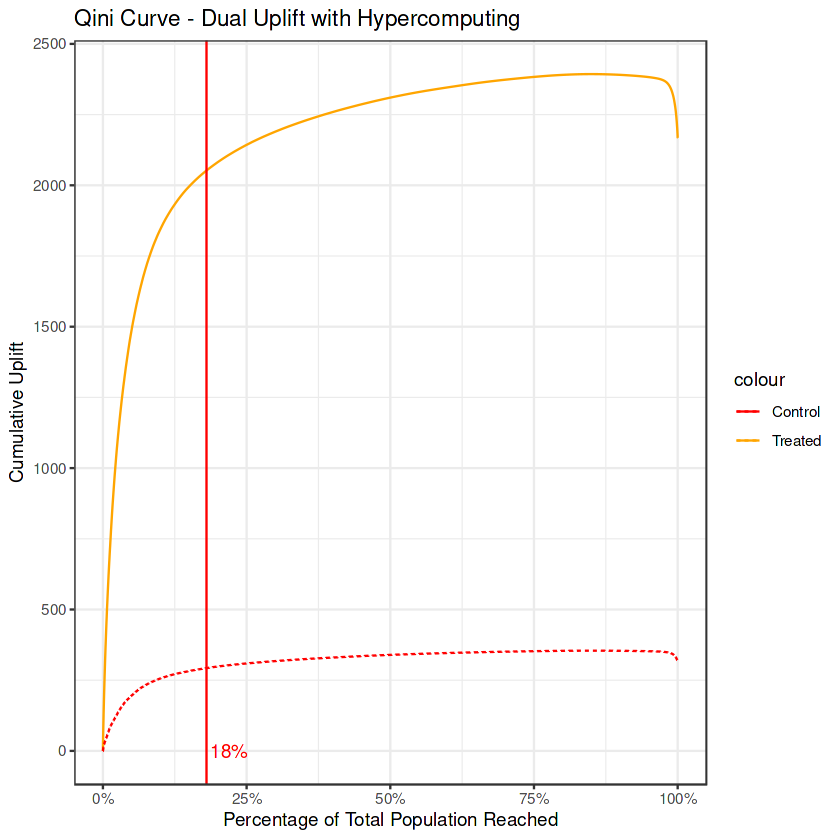

In [45]:
library(ggplot2)

# Calculate the percentage of the total population reached
hyper_total_population <- nrow(hyper_sorted_data)
hyper_percentage_reached <- seq(0, 100, length.out = hyper_total_population)

# Create a data frame for the Qini curve
hyper_qini_curve_data <- data.frame(Percentage_Reached = hyper_percentage_reached,
                              Cum_Uplift_Treated = hyper_cum_uplift_treated,
                              Cum_Uplift_Control = hyper_cum_uplift_control)

# Plot the Qini curve
ggplot(hyper_qini_curve_data, aes(x = Percentage_Reached)) +
  geom_line(aes(y = Cum_Uplift_Treated, color = "Treated"), linetype = "solid") +
  geom_line(aes(y = Cum_Uplift_Control, color = "Control"), linetype = "dashed") +
  scale_color_manual(values = c("Treated" = "orange", "Control" = "red")) +
  labs(x = "Percentage of Total Population Reached",
       y = "Cumulative Uplift",
       title = "Qini Curve - Dual Uplift with Hypercomputing") +
   theme_bw() +
  geom_vline(xintercept = 18, color = "red", linetype = "solid") +
  scale_x_continuous(labels = scales::percent_format(scale = 1)) +
  annotate("text", x = 22, y = -0.05, label = "18%", color = "red")

The above results visualises the qini curve that was developed using the dual uplift model with the use of hypercomputing for both Treated and control groups. In the given dataset 0%-18% of the population represented in the curve can be identified as “Persuadables”. The 18%-96% of the population can be identified as “Sure things” and “Lost causes”. While 96%-100% of the population can be identified as “Sleeping dogs”.

# Discussion

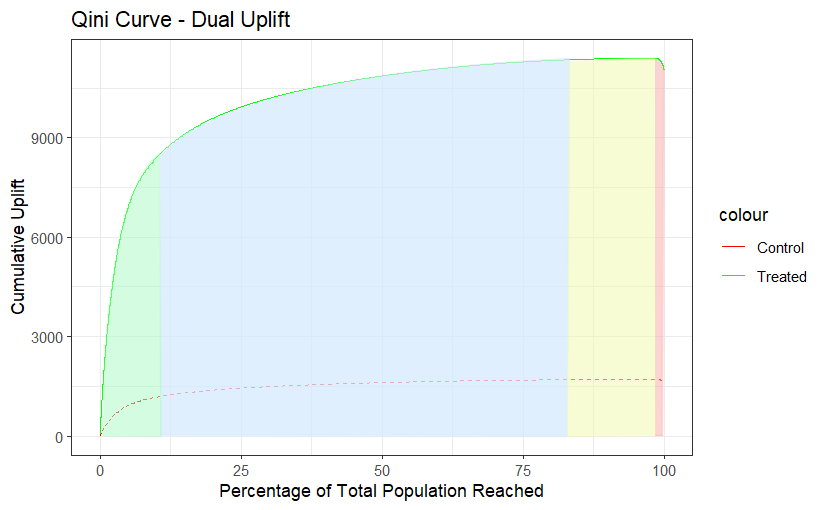

The above results illustrates the qini curve for the dual uplift model that was developed using the Criteo uplift dataset. The area highlighted in ‘Green’ which is 9% of the population can be identified as “Persuadables”. In the qini curve, these persuadables are represented by the upward slope and targeting this customer segmentation can create a positive impact towards the marketing campaign. However, when the curve starts to level off, it suggests that most of the customers who identified as “Persuadables” have been identified and further targeting may not create significant value addition to the marketing campaign. The area highlighted in ‘Blue’ which is 73.5% of the population can be identified as “Sure Things”. In the qini curve, these Sure Things represent the upwards moderate slope and suggest that this customer segmentation has a slight uplift that can be used to target marketing if needed. The shape of the qini curve area indicates the gradual decrease in incremental uplift with the given time. However, targeting Sure Things will not create a significant impact on the campaign because of the nature of the Sure Things customer category. Even though they are targeted, these customers tend to purchase the product. Therefore, targeting them will increase the expenses without getting any benefit. The area highlighted in ‘Yellow which is 16% of the population can be identified as “Lost Causes”. In the qini curve, these Lost Causes are represented by the near-flat slope or even a downward trend in the curve. The shape of the curve area reflects the customer response to the treatment was either negligible or negative. Targeting these customers does not create value for the campaigns since these customers would never buy the product regardless of the advertising campaign. Targeting them only increases expenses. Finally, The area highlighted in ‘Red’ which is 1.5% of the population can be identified as “Sleeping Dogs”. In the qini curve, these Sleeping Dogs represent the steady or slightly decreasing uplift trend and targeting this customer segmentation can create a negative impact towards the marketing campaign. These customers will not respond to the treatment and they potentially have negative incremental uplift value. These customers will become unwilling to purchase a product after being exposed to a campaign.

# Model Performance Comparison

## Qini Curve: All Models

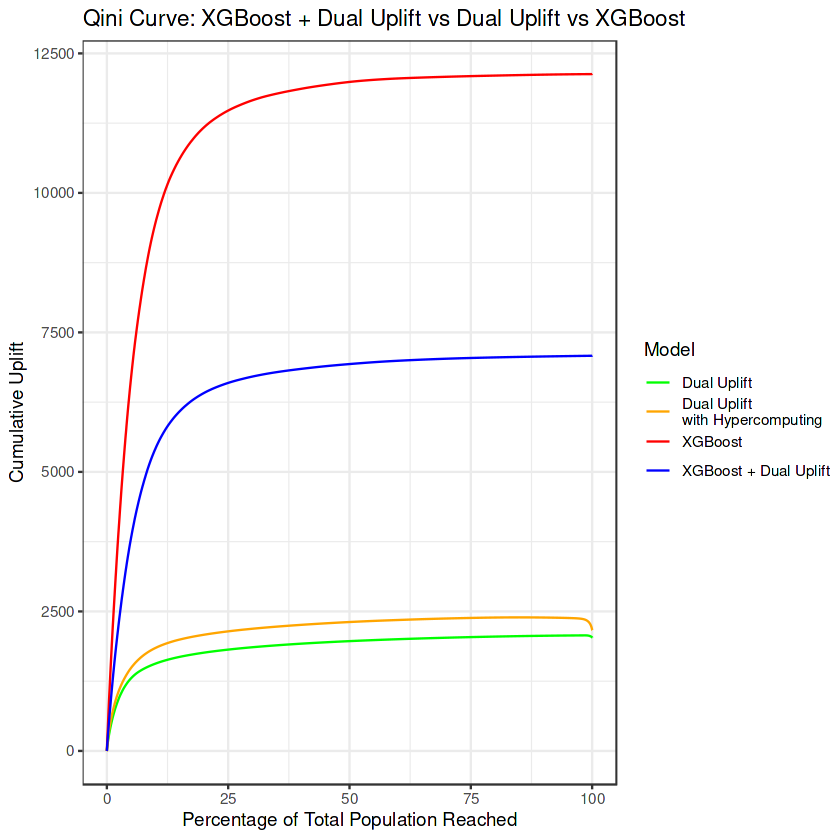

In [46]:
library(ggplot2)
# Merge the data frames and add a column to differentiate between the models
combined_qini_curve_data <- rbind(
  transform(com_xgb_qini_curve_data, Model = "XGBoost + Dual Uplift"),
  transform(qini_curve_data, Model = "Dual Uplift"),
  transform(hyper_qini_curve_data, Model = "Dual Uplift \nwith Hypercomputing"),
  transform(xgb_qini_curve_data, Model = "XGBoost")
)

# Plot the combined data
ggplot(combined_qini_curve_data, aes(x = Percentage_Reached, y = Cum_Uplift_Treated, color = Model)) +
  geom_line(linetype = "solid") +
  scale_color_manual(values = c("XGBoost + Dual Uplift" = "blue", "Dual Uplift" = "green","Dual Uplift \nwith Hypercomputing" = "orange", "XGBoost" = "red")) +
  labs(x = "Percentage of Total Population Reached",
       y = "Cumulative Uplift",
       title = "Qini Curve: XGBoost + Dual Uplift vs Dual Uplift vs XGBoost") +
  theme_bw()

The above results illustrates all three models' qini curves to have a better understanding of each model's performance for the criteo uplift dataset. The shape of the Qini curve mainly depends on the model approach along with the nature of the tested dataset. With the involvement of the XGBoost model, the customer received a higher cumulative uplift value when compared to the other models. This is one of the main reasons that those Qini curves have different shapes. However, Having all possible models in a single application creates benefits for its users. Based on the dataset, a suitable model can be deployed to achieve the organisation's goals.

## Qini Curve: Dual Uplift vs Dual Uplift with Hypercomputing

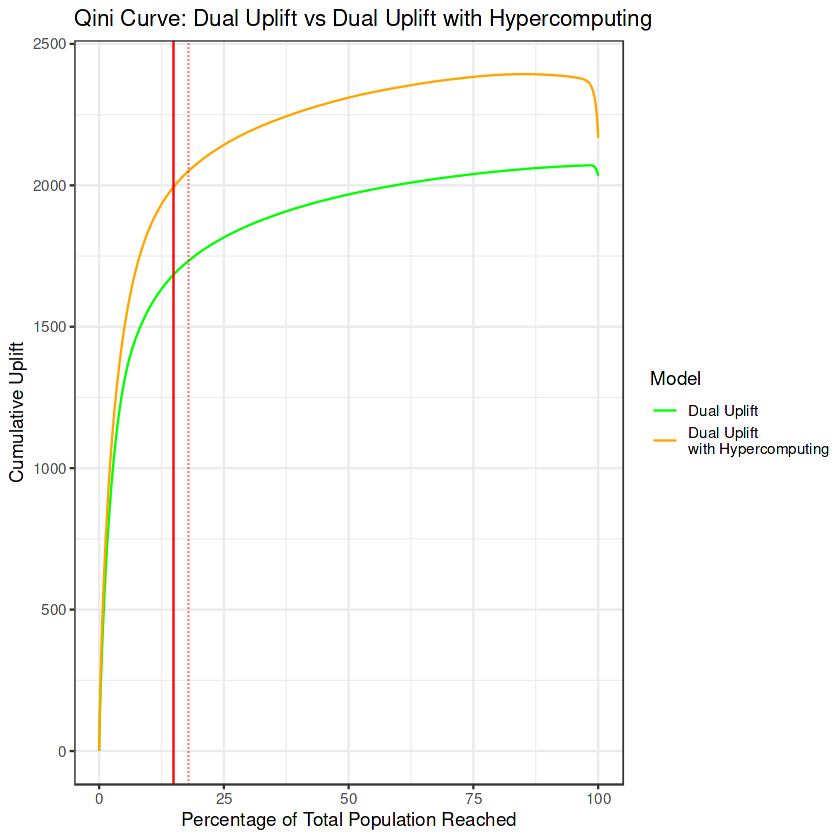

In [47]:
library(ggplot2)
# Merge the data frames and add a column to differentiate between the models
combined_qini_curve_data <- rbind(
  transform(qini_curve_data, Model = "Dual Uplift"),
  transform(hyper_qini_curve_data, Model = "Dual Uplift \nwith Hypercomputing")
)

# Plot the combined data
ggplot(combined_qini_curve_data, aes(x = Percentage_Reached, y = Cum_Uplift_Treated, color = Model)) +
  geom_line(linetype = "solid") +
  scale_color_manual(values = c("Dual Uplift" = "green","Dual Uplift \nwith Hypercomputing" = "orange")) +
  labs(x = "Percentage of Total Population Reached",
       y = "Cumulative Uplift",
       title = "Qini Curve: Dual Uplift vs Dual Uplift with Hypercomputing") +
   theme_bw() +
  geom_vline(xintercept = 15, color = "red", linetype = "solid") +
  geom_vline(xintercept = 18, color = "red", linetype = "dotted")

The results of the study describe the dual uplift model usability when compared to the Criteo uplift dataset. However, when dealing with these types of large datasets for predictions, other factors also need to be considered. Such as, when models directly use these types of large data, the accuracy of the model may drop. This can lead to model overfit or underfit for the given dataset. In addition to that, to process these types of large data, the model requires more time. This will decrease the model's feasibility. To overcome this concern, the study performs parallel processing while training multiple Dual Uplift models simultaneously on different subsets of the dataset. The study processes 12 models in parallel using 8 cores in the CPU with the current dataset. This number of models can be increased further and while increasing the same the overall execution time can be drastically reduced. However, having more models for parallel processing requires higher computational resources. Including CPU cores and memory (RAM). As a limitation, in case of low resources may lead to program crashes.

The above results visualises the results of the dual uplift model and dual uplift model with parallelisation. The results were evident that the model that used parallelisation outperformed the model that did not include parallelisation. In the model without parallelisation, “Persuadables” customers can be identified as 0%-15% of the population while in the model with parallelisation, “Persuadables” customers can be identified as 0%-18% of the population. However, when considering the time, the dual uplift model took 1 minute and 23 seconds to complete the training process while the model with hypercomputing took 2 minutes and 39 seconds. This occurs mainly, in the model without parallelisation using fewer computational resources to train a single model with a large dataset while the model with parallelisation performed using multiple models as a cluster basis. This process demands higher computational resources, such as memory and CPU to train multiple models simultaneously. Even though the process minimises the error and increases the accuracy, without having proper computational resources, this process may have functional difficulties. 

## Qini Curve: XGBoost vs Dual Uplift + XGBoost

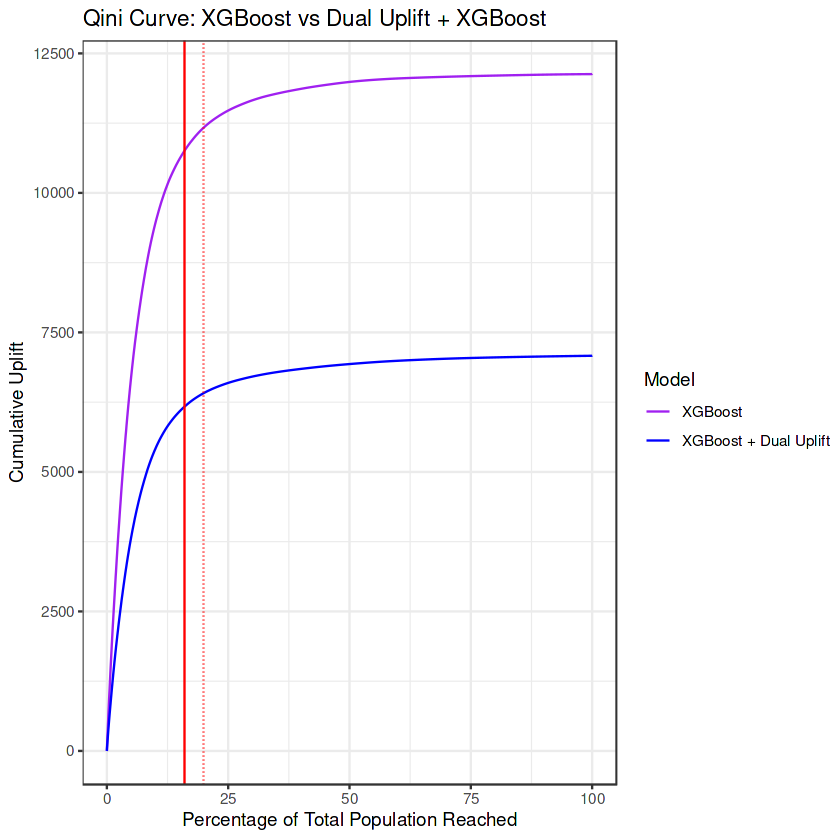

In [48]:
library(ggplot2)
# Merge the data frames and add a column to differentiate between the models
combined_qini_curve_data <- rbind(
  transform(com_xgb_qini_curve_data, Model = "XGBoost + Dual Uplift"),
  transform(xgb_qini_curve_data, Model = "XGBoost")
)

# Plot the combined data
ggplot(combined_qini_curve_data, aes(x = Percentage_Reached, y = Cum_Uplift_Treated, color = Model)) +
  geom_line(linetype = "solid") +
  scale_color_manual(values = c("XGBoost + Dual Uplift" = "blue","XGBoost" = "purple")) +
  labs(x = "Percentage of Total Population Reached",
       y = "Cumulative Uplift",
       title = "Qini Curve: XGBoost vs Dual Uplift + XGBoost") +
   theme_bw() +
  geom_vline(xintercept = 16, color = "red", linetype = "solid") +
  geom_vline(xintercept = 20, color = "red", linetype = "dotted")

The above results visualises the results of the XGBoost model and combined model that include both the dual uplift model and XGBoost models. The results were evident that the XGBoost model had a higher Qini curve when compared to the combined model. When identifying  “Persuadables” customers in both models, XGBoost models predict 0%-20% of customers as persuadable customers with 95% accuracy and the combined model predicts 0%-16% of customers as persuadable customers with 95% accuracy. These results were evident that, with the integration of the dual uplift model with the XGBoost model, the potential misprediction of the regular XGBoost model was reduced while maintaining the same accuracy. However, when considering the time, the regular XGBoost model took 42 seconds to complete the training process while the combined model with hypercomputing took 3 minutes and 24 seconds. This occurs mainly because the algorithm is designed to predict using test data separately in both models and combine them. This consumes more time along with computational resources.

When combining models the study used the soft vote method. Other than soft voting, methods such as hard voting which directly selected the majority prediction as the final output of the model. Training multiple instances of the same model trained using a different subset of the training dataset and calculating the average of the predictions. Lastly, rather than considering equal weights for each prediction, different weights were assigned for the different models based on their performance. This enables to provide more importance to the model that has high and reliable performance to the given dataset. Adopting different ensemble approaches can increase the accuracy of the model. Similarly the same can apply within the study to increase uplift prediction accuracy.

## Qini Curve: XGBoost + Dual Uplift vs Dual Uplift with Hypercomputing

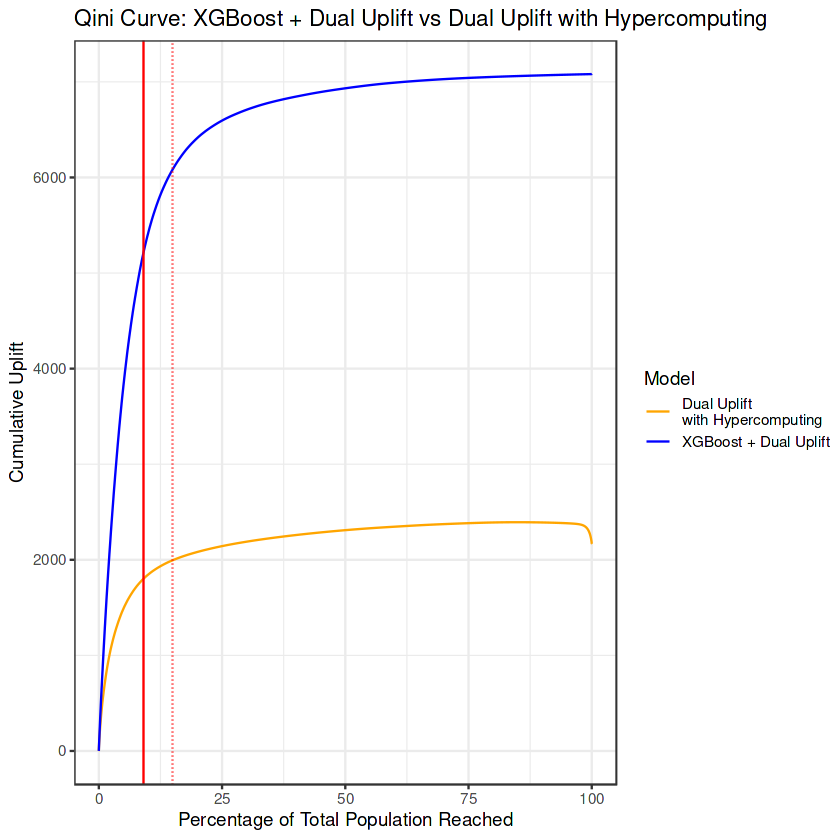

In [49]:
library(ggplot2)
# Merge the data frames and add a column to differentiate between the models
combined_qini_curve_data <- rbind(
  transform(com_xgb_qini_curve_data, Model = "XGBoost + Dual Uplift"),
  transform(hyper_qini_curve_data, Model = "Dual Uplift \nwith Hypercomputing")
)

# Plot the combined data
ggplot(combined_qini_curve_data, aes(x = Percentage_Reached, y = Cum_Uplift_Treated, color = Model)) +
  geom_line(linetype = "solid") +
  scale_color_manual(values = c("XGBoost + Dual Uplift" = "blue","Dual Uplift \nwith Hypercomputing" = "orange")) +
  labs(x = "Percentage of Total Population Reached",
       y = "Cumulative Uplift",
       title = "Qini Curve: XGBoost + Dual Uplift vs Dual Uplift with Hypercomputing") +
   theme_bw() +
  geom_vline(xintercept = 9, color = "red", linetype = "solid") +
  geom_vline(xintercept = 15, color = "red", linetype = "dotted")

The above results visualises the comparison between the combined model and dual uplift model with hypercomputing. The results were evident that the combined model had a higher Qini curve when compared to the dual uplift model with hypercomputing. When identifying  “Persuadables” customers in both models, the combined model visualises 0%-15% of customers as persuadable customers and the dual uplift model with hypercomputing visualises 0%-9% of customers as persuadable customers for the given dataset. However, the Qini curve output visualises significant differences between the two models. This can cause many reasons. Such as these two models may have different levels of complexity. Having a higher complex model capable of capturing hidden patterns in data. In addition to that, in some instances, the models may involve randomness in the algorithms. This can lead to prediction variations among the models. Lastly, the combined model might have a different balance between bias and variance compared to the dual uplift model with hypercomputing. This sensitivity might cause such variance in the dataset.

# Conclusion

The study discovered that the dual uplift model can be used to predict potential customers who positively react to direct marketing campaigns. The results show that the dual uplift model is capable of clearly segregating the four segments of the customer in the uplift concept which are Sure Things, Lost Causes,  Sleeping Dogs and Persuadable using the Qini Curve. With the hypercomputing integration for the Dual Uplift modelling, the study found that hyper computing approach provides better results than the regular model approach when comes to large datasets. In addition, the study discovered the combined models capable of providing better performance using their own predictive characteristics while mitigating errors generated by individual models.